## Context

- in PAL005, I used mixscape to analyze the preturbations, and I'm reasonably confident that the annotations are correct
- in this notebook, i'd like to focus on DE gene analysis
- for a first pass, i'll do a simple DE gene analysis using pairwise comparisons
- next i'll use GSEApy to examine gene modules
- if it makes sense, I may repeat some or all of these steps after data imputation with magic
- it may also be worthwile to use cellbender to remove background noise and repeat the preprocessing done in PAL005

- First pass is a simple DE test with wilcoxon on zscores
- next, we can do some psuedobulk with EdgeR and see what we get 
- 

## Libraries + Settings

In [208]:
import scanpy as sc
import pandas as pd
import numpy as np
import mudata as mu
import plotnine as p9
from scipy.sparse import csr_matrix

In [218]:
sc.set_figure_params(frameon=False, dpi=100)
%config InlineBackend.figure_format = 'retina'
%load_ext slurm_magic

The slurm_magic extension is already loaded. To reload it, use:
  %reload_ext slurm_magic


## Data Import

In [210]:
mdata = mu.read_h5mu("/lustre/fs4/cao_lab/scratch/plaffont/personal_datasets/CTR02/ctr02_processed.h5mu")
mdata

MuData object with n_obs × n_vars = 17049 × 32303
  var:	'gene_ids', 'feature_types', 'genome', 'pattern', 'read', 'sequence', 'target_gene_id', 'target_gene_name'
  3 modalities
    rna:	17029 x 32286
      obs:	'spleen-CD62Lpos', 'spleen-CD62Lneg', 'mLN-CD62Lpos', 'mLN-CD62Lneg', 'most_likely_hypothesis', 'cluster_feature', 'negative_hypothesis_probability', 'singlet_hypothesis_probability', 'doublet_hypothesis_probability', 'Classification', 'num_features', 'feature_call', 'num_umis', 'target', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'mixscape_class_p_ko', 'mixscape_class', 'mixscape_class_global'
      var:	'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
      uns:	'hvg', 'log1p', 'mixscape', 'pca'
      obsm:	'X_pca'
      varm:	'PCs'
      layers:	'X_pert', 'counts'
    guide:	17049 x 12
      var:	'gene_ids', 'feature_types', 'pattern', 'read', 'sequence', 'target_gene_id', 'target_gene_name'
    cite:	17049 x 5
      var:	'gene_ids', 'feature_types', 'genome', 'pattern', 'read', 'sequence'

In [211]:
# for this analysis we're only going to need the rna

rna = mdata["rna"].copy()

del mdata

rna

AnnData object with n_obs × n_vars = 17029 × 32286
    obs: 'spleen-CD62Lpos', 'spleen-CD62Lneg', 'mLN-CD62Lpos', 'mLN-CD62Lneg', 'most_likely_hypothesis', 'cluster_feature', 'negative_hypothesis_probability', 'singlet_hypothesis_probability', 'doublet_hypothesis_probability', 'Classification', 'num_features', 'feature_call', 'num_umis', 'target', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'mixscape_class_p_ko', 'mixscape_class', 'mixscape_class_global'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'mixscape', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'X_pert', 'counts'

## Simple DE on zscores

### On all Genes

/lustre/fs4/cao_lab/store/plaffont/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
/lustre/fs4/cao_lab/store/plaffont/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
/lustre/fs4/cao_lab/store/plaffont/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2


categories: Ifngr1 KO, Ifngr1 NP, NT, etc.
var_group_labels: Ifngr1 KO, Ifngr1 NP, Tgfbr2 KO, etc.


/lustre/fs4/cao_lab/store/plaffont/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2


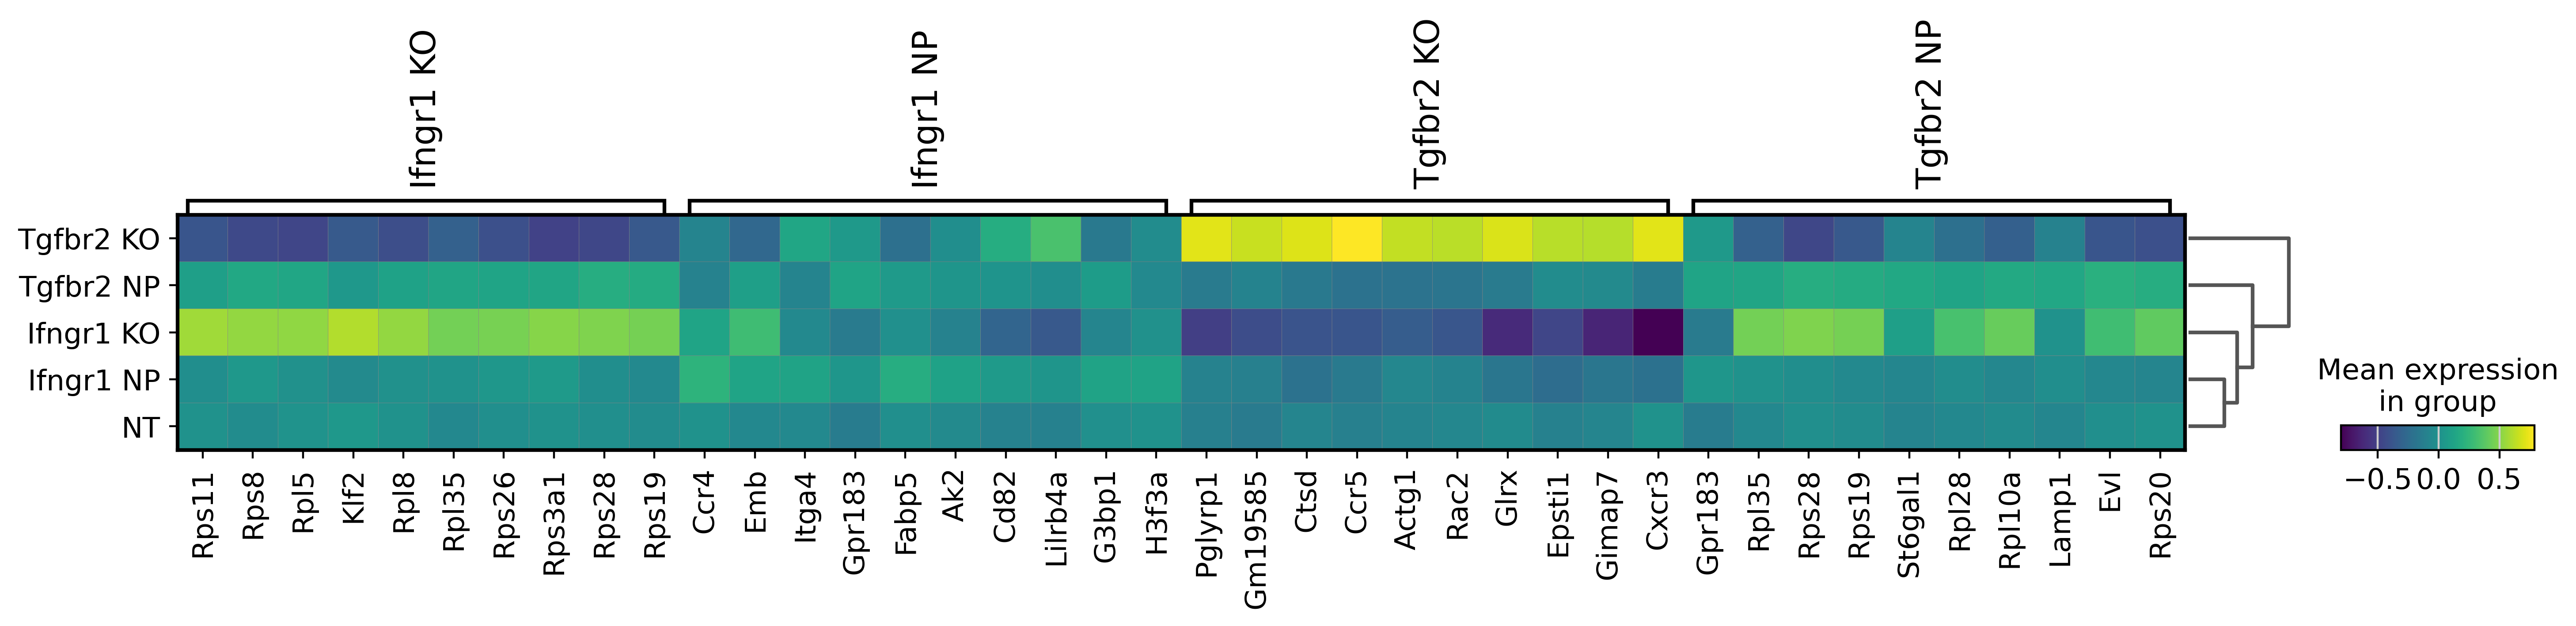

In [212]:
sc.tl.rank_genes_groups(
    adata=rna, 
    groupby="mixscape_class", 
    reference="NT", 
    key_added="DE_zscores_allgenes",
    method="wilcoxon"
)

sc.pl.rank_genes_groups_matrixplot(rna, key = "DE_zscores_allgenes")

/lustre/fs4/cao_lab/store/plaffont/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 25268 rows containing missing values.


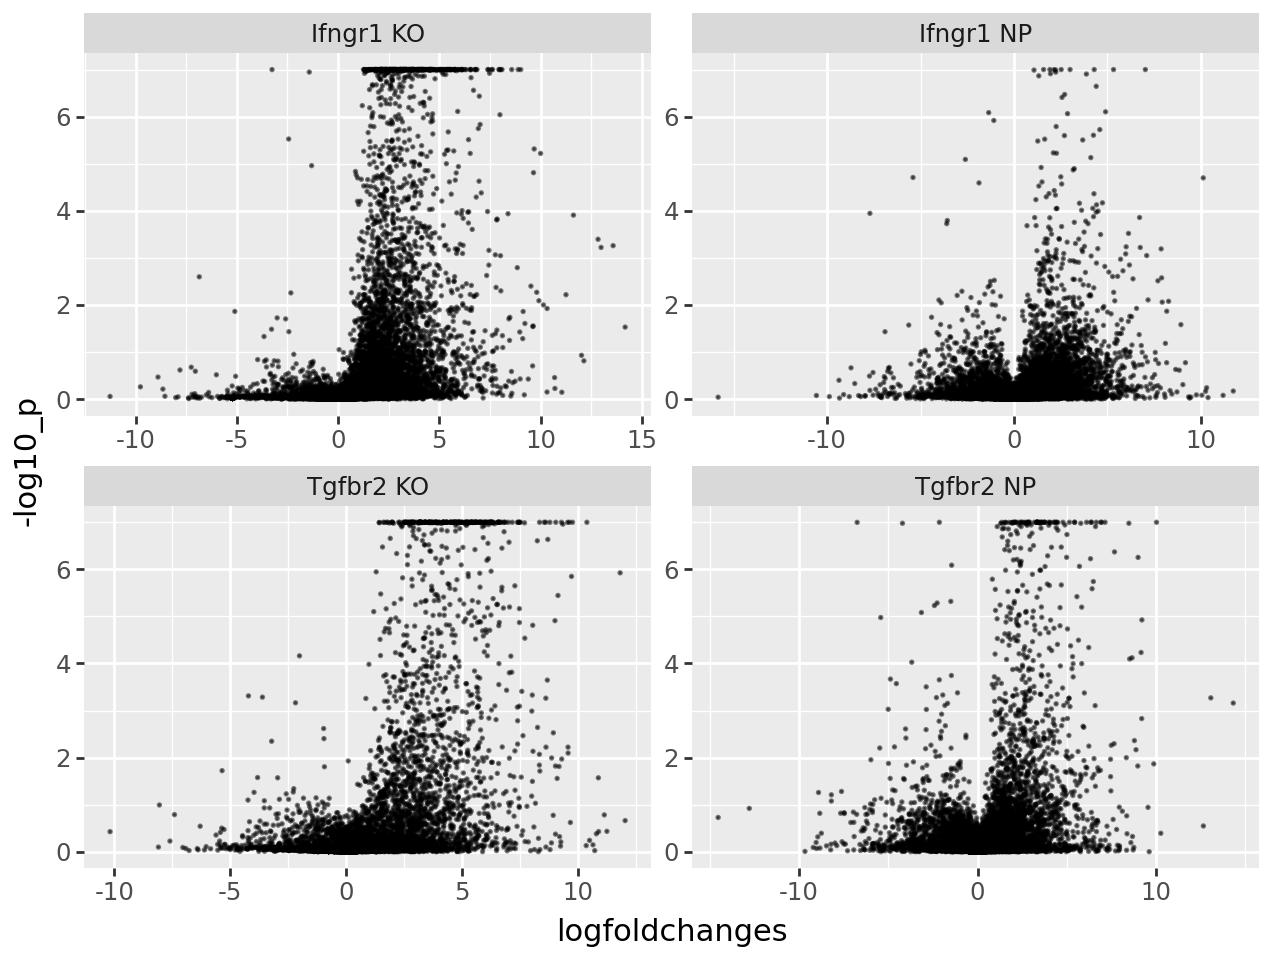

In [214]:
de_df = sc.get.rank_genes_groups_df(rna, group = None, key= "DE_zscores_allgenes")
de_df["-log10_p"] = -np.log10(de_df.pvals + 0.0000001)

(
    p9.ggplot(de_df, p9.aes(x = "logfoldchanges", y = "-log10_p")) +
    p9.geom_point(size = 0.1, alpha = 0.5) +
    p9.facet_wrap("~group", scales = "free")
)

### Drop ribosomal genes

In [215]:
rna.var["rb"] = rna.var_names.str.startswith(("Rps", "Rpl"))

rna = rna[:, ~rna.var.rb]

/lustre/fs4/cao_lab/store/plaffont/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
/lustre/fs4/cao_lab/store/plaffont/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
/lustre/fs4/cao_lab/store/plaffont/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
/lustre/fs4/cao_lab/store/plaffont/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2


categories: Ifngr1 KO, Ifngr1 NP, NT, etc.
var_group_labels: Ifngr1 KO, Ifngr1 NP, Tgfbr2 KO, etc.


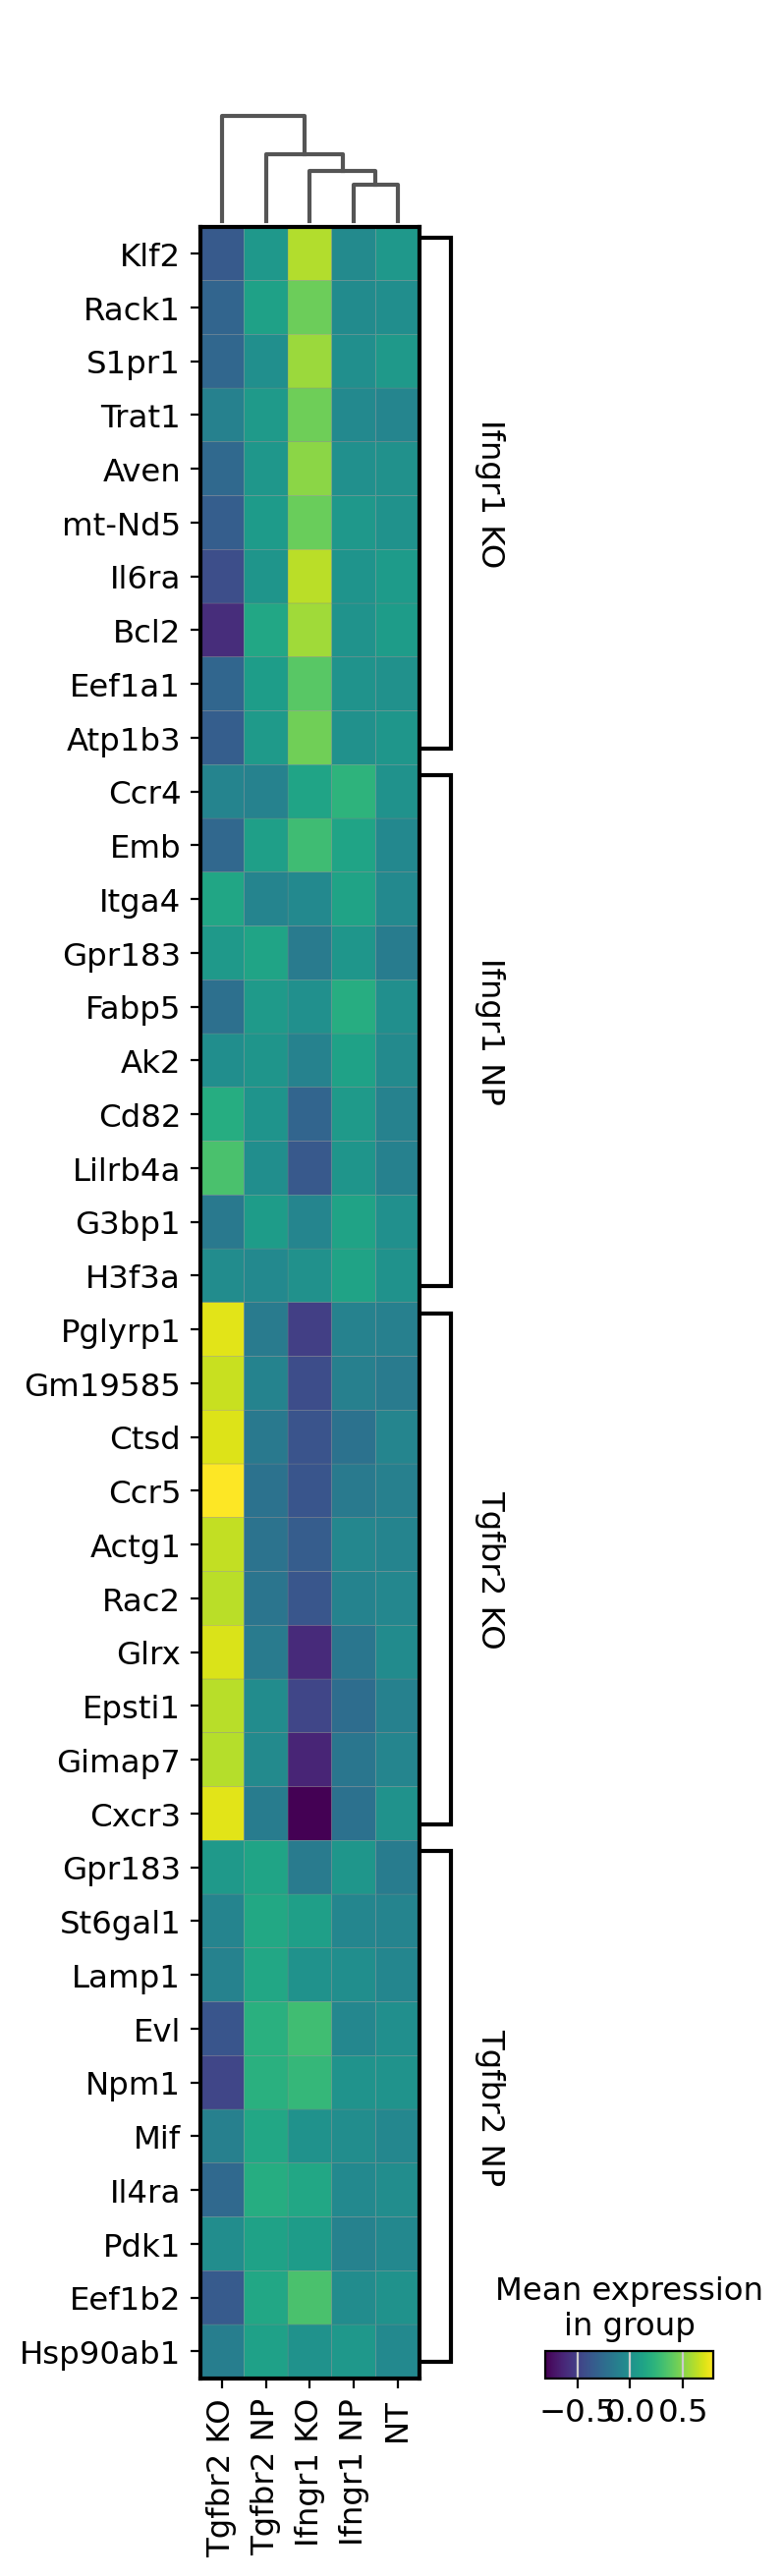

In [219]:
sc.tl.rank_genes_groups(
    adata=rna, 
    groupby="mixscape_class", 
    reference="NT", 
    key_added="DE_zscores_noRb",
    method="wilcoxon"
)

sc.pl.rank_genes_groups_matrixplot(rna, key = "DE_zscores_noRb", swap_axes = True)

/lustre/fs4/cao_lab/store/plaffont/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 25077 rows containing missing values.


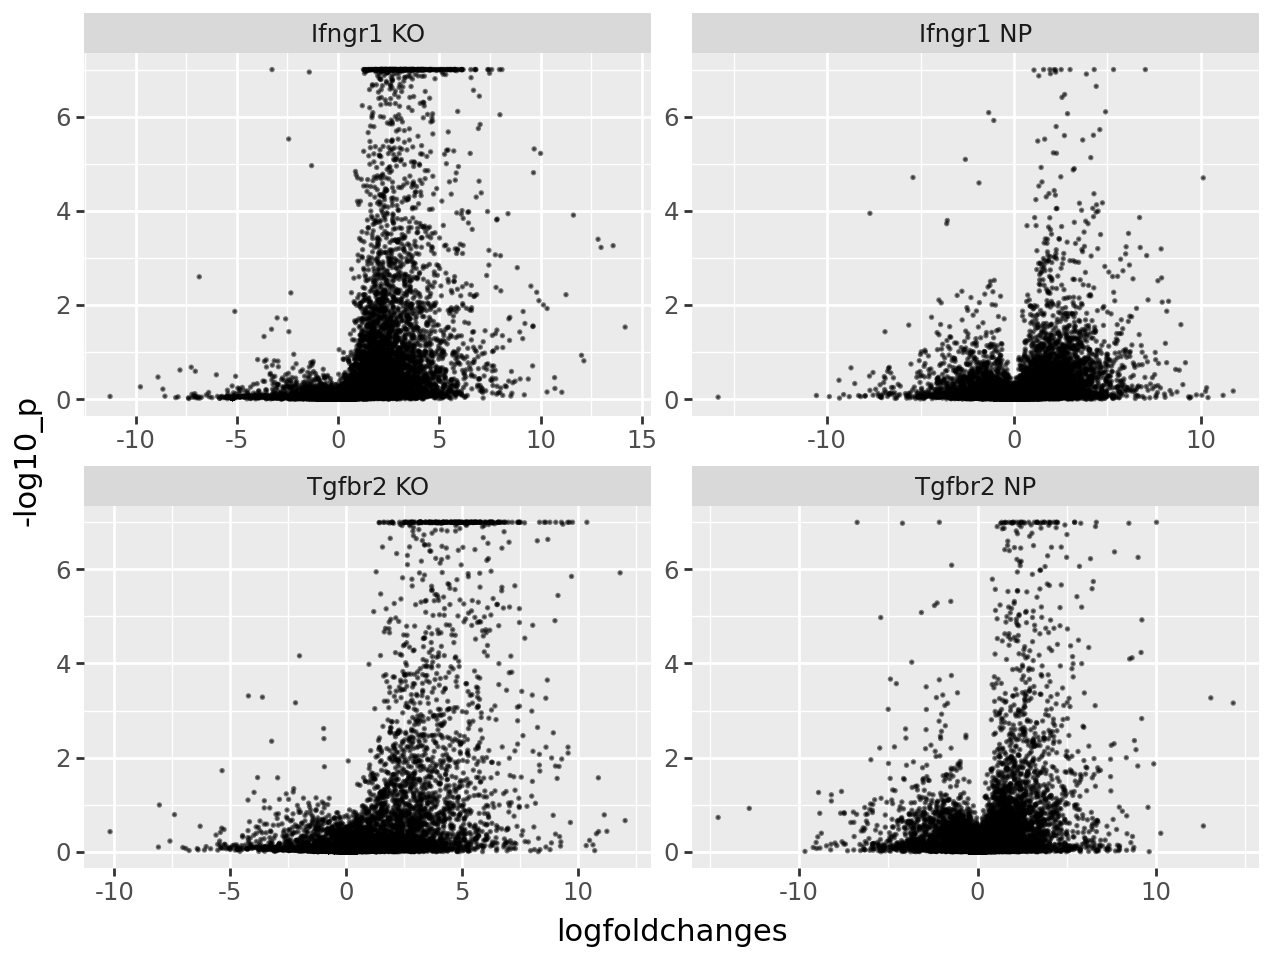

In [217]:
de_df = sc.get.rank_genes_groups_df(rna, group = None, key= "DE_zscores_noRb")
de_df["-log10_p"] = -np.log10(de_df.pvals + 0.0000001)

(
    p9.ggplot(de_df, p9.aes(x = "logfoldchanges", y = "-log10_p")) +
    p9.geom_point(size = 0.1, alpha = 0.5) +
    p9.facet_wrap("~group", scales = "free")
)

## Psuedobulk with EdgeR

## Gene set enrichment with GSEApy 